In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import StandardScaler

directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sensitivity_folder=r'Sensitivity Analysis'
sensitivity_file = r'sensitivity_analysis_processed.csv'
sensitivity_results=r'Results'

sensitivity_figures_folder=r'careFarmMean-carePatchMean'

clusters_folder="Clusters"
subsidy_max=10

sensitivity_csv = pd.read_csv(os.path.join(directory, sensitivity_folder, sensitivity_file), engine='python')

countries=['Vietnam', 'Cambodia']

metrics_title=['Income Per Patch',
 'Net Production Per Patch',
 'NCH Patches',
 'Non-HS Strategy',
 'Production Benefit Per NCH Patch',
 'Income Deviation',
 'HS Patches',
 'HS Strategy'
 ]

metrics_ordered=[
 'Non-HS Strategy',
 'Production Benefit Per NCH Patch',
 'Net Production Per Patch',
 'NCH Patches',
 'HS Patches',
 'Income Per Patch',
 'Income Deviation'
 ]

metrics=['Income Per Patch',
 'Net Production Per Patch',
 'NCH Patches (%)',
 'Non-HS Strategy (%)',
 'Production Benefit Per NCH Patch',
 'Income Deviation',
 'HS Patches (%)',
 'HS Strategy (%)']

set_percent_inds=[2, 3, 6, 9, 10, 11]

metrics_index=16

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
def to_percentage(x, pos):
    return f'{x * 100:.0f}%'
def to_percentage_decimal(x, pos):
    return f'{x * 100:.1f}%'

In [2]:
plt.rcParams.update({'font.size': 16}) # label font size
title_size=18 # title font size
padding_title_size=20 # padding between title and rest of figure

In [3]:
# nested list for each subsidy
data=[]
curr_subsidy=-1
prev_ind=-1

for i in range(len(sensitivity_csv)):
    if sensitivity_csv['subsidy'][i]!=curr_subsidy:
        if curr_subsidy!=-1:
            data.append(sensitivity_csv.iloc[prev_ind:i])

        curr_subsidy+=1
        prev_ind=i
    
data.append(sensitivity_csv.iloc[prev_ind:])

# sensitivity analysis results with CareDifference (normalized to x-axis )

In [7]:
# finding average values for Vietnam and Cambodia across farm size and heterogeneity experiments

df=pd.read_csv(join(directory, sensitivity_folder, 'farm_size_analysis.csv'))

subsidy_max=10
country_data=dict()

curr_param='listNCHCells'
# curr_param='listHSCells'

country='Vietnam'
country_data[country]=[[] for _ in range(subsidy_max+1)]

ind=0
prev_ind=ind
while ind < len(df) and df['country'].iloc[ind+1]==country:
    ind+=1

full_list=df[curr_param].tolist()[prev_ind:ind+1]
for i in range(len(full_list)):
    full_list[i]=full_list[i][1:-1].split(" ")
    for j in range(len(full_list[i])):
        country_data[country][j].append(float(full_list[i][j]))


country='Cambodia'
country_data[country]=[[] for _ in range(subsidy_max+1)]

full_list=df[curr_param].tolist()[ind+1:]
for i in range(len(full_list)):
    full_list[i]=full_list[i][1:-1].split(" ")
    for j in range(len(full_list[i])):
        country_data[country][j].append(float(full_list[i][j]))

# heterogeniety
df=pd.read_csv(join(directory, sensitivity_folder, 'heterogeneity_analysis.csv'))

country='Vietnam'

ind=0
prev_ind=ind
while ind < len(df) and df['country'].iloc[ind+1]==country:
    ind+=1

full_list=df[curr_param].tolist()[prev_ind:ind+1]
for i in range(len(full_list)):
    full_list[i]=full_list[i][1:-1].split(" ")
    for j in range(len(full_list[i])):
        country_data[country][j].append(float(full_list[i][j]))


country='Cambodia'
full_list=df[curr_param].tolist()[ind+1:]
for i in range(len(full_list)):
    full_list[i]=full_list[i][1:-1].split(" ")
    for j in range(len(full_list[i])):
        country_data[country][j].append(float(full_list[i][j]))

In [8]:
for country in countries:
    for subsidy in range(subsidy_max+1):
        country_data[country][subsidy]=np.mean(country_data[country][subsidy])

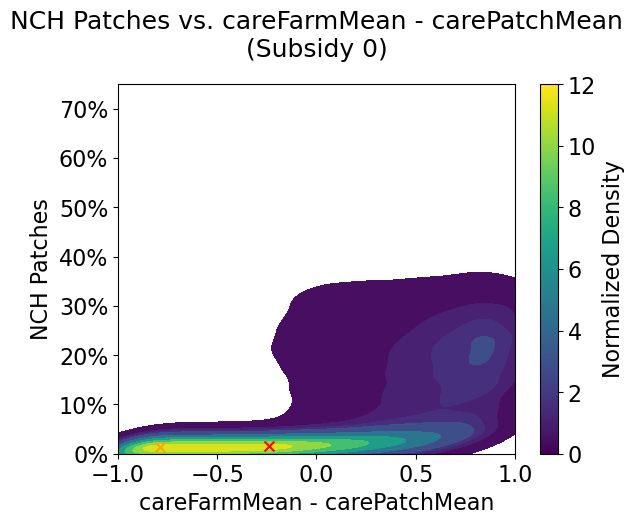

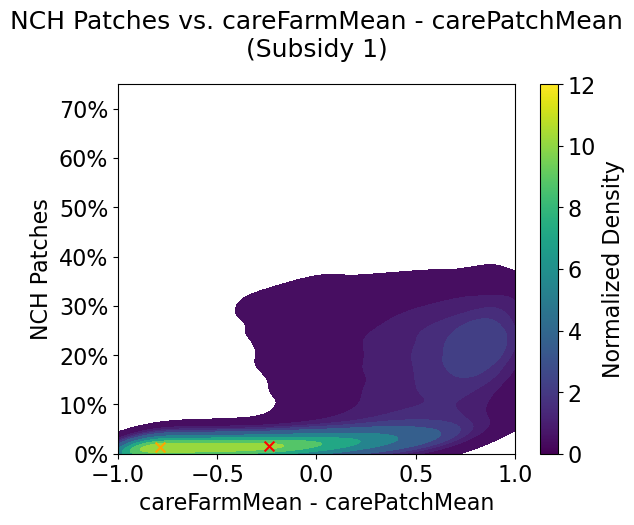

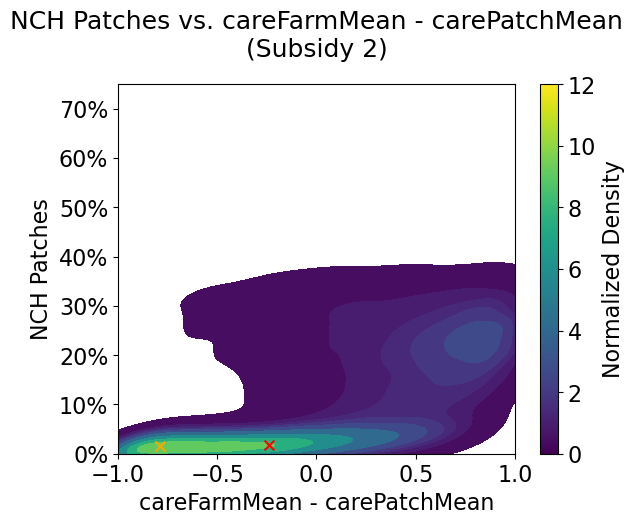

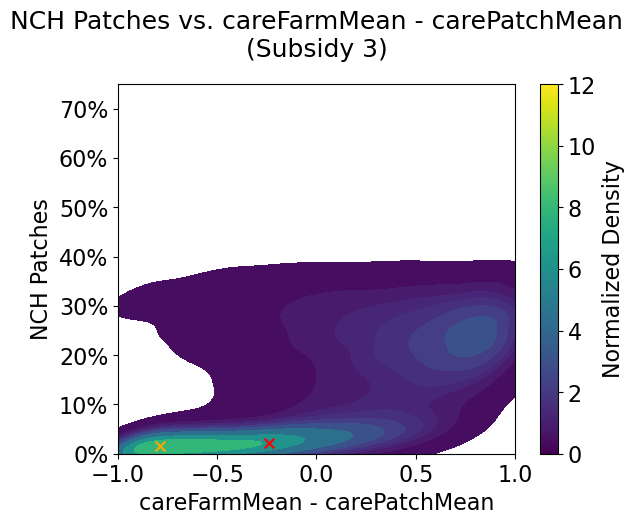

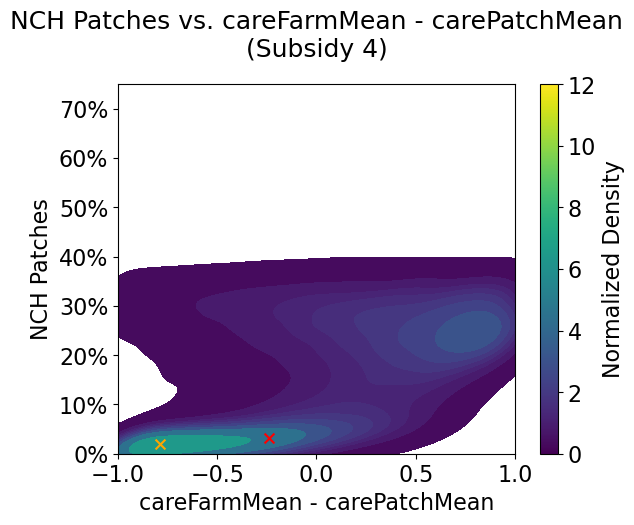

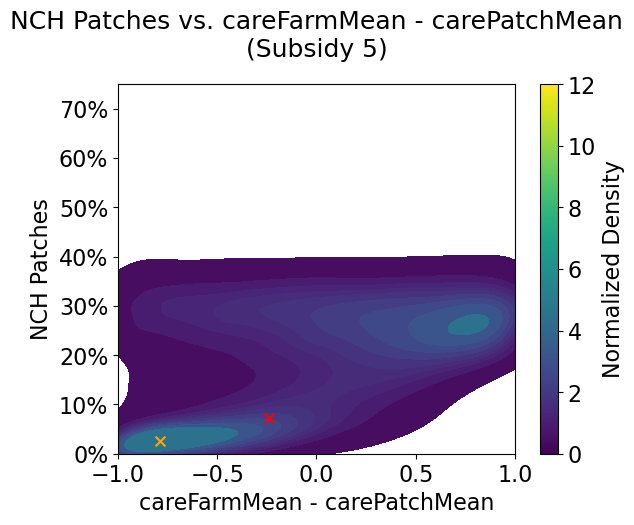

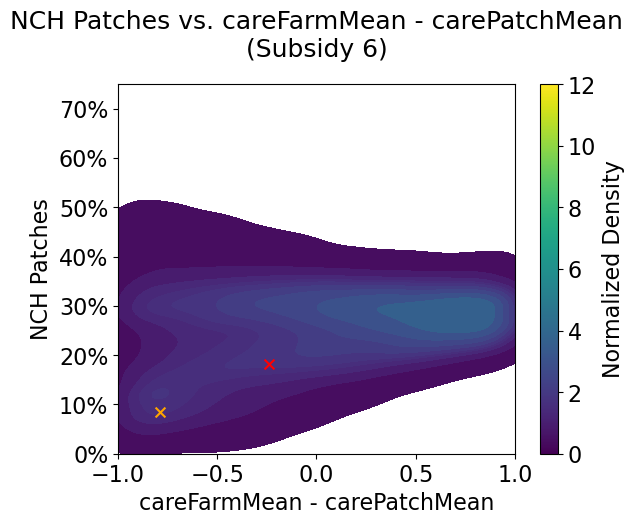

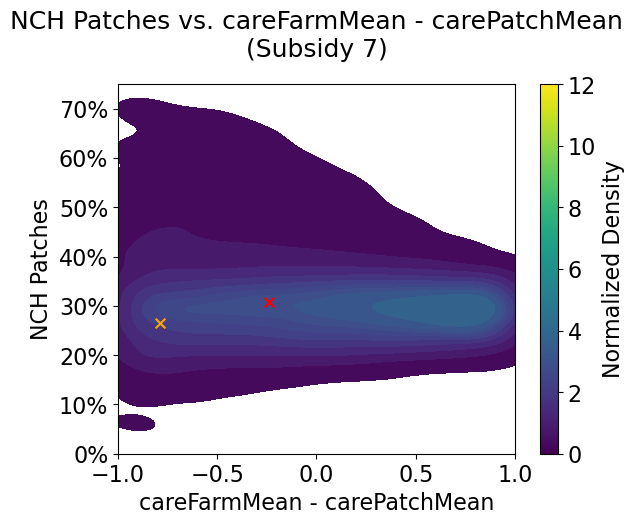

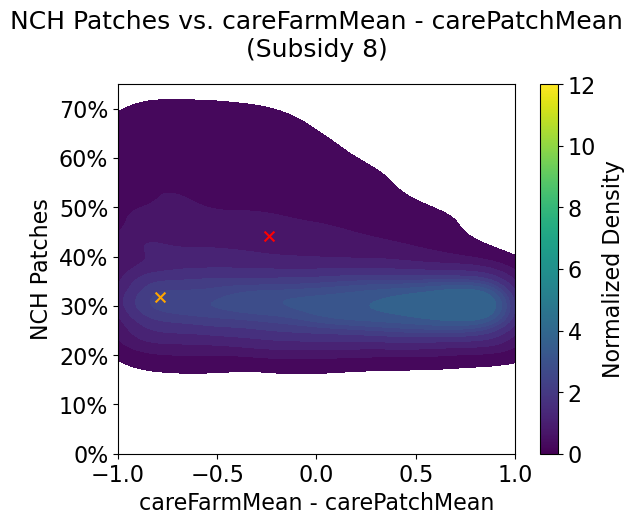

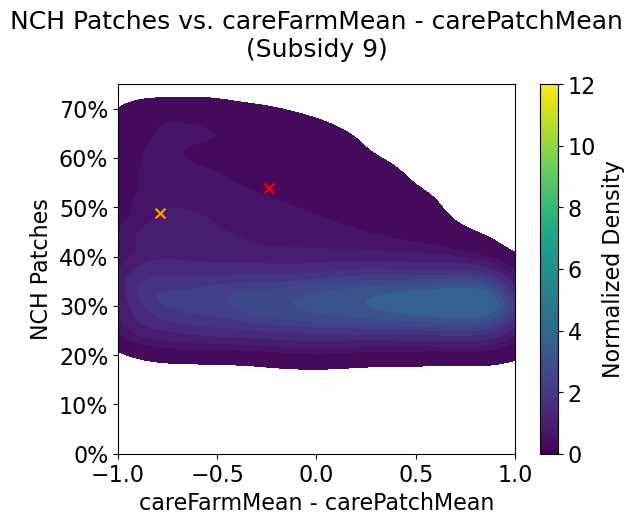

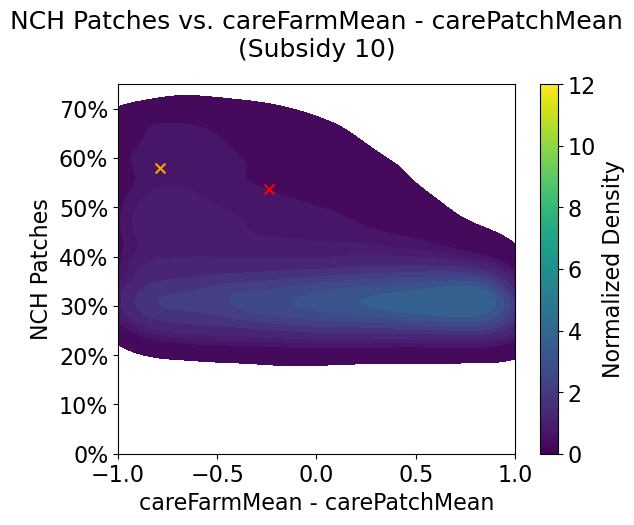

In [167]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# calibrated careFarmMean-carePatchMean
x_vietnam=-0.24
x_cambodia=-0.79

for subsidy in range(subsidy_max+1):
# for subsidy in [10]:
    fig, ax = plt.subplots()
    
    x = data[subsidy]['careFarmerMean'] - data[subsidy]['carePatchMean']
    y = data[subsidy]['listNCHCells']
    
    kde_x = gaussian_kde(x)
    x_density = kde_x(x)

    # weights as the inverse of the x-density to normalize 
    weights = 1 / (x_density)
    kde=sns.kdeplot(x=x, y=y, weights=weights, fill=True, cmap='viridis', thresh=0.01, ax=ax,
                     cbar=False)

    norm = plt.Normalize(vmin=0, vmax=12)
    for collection in kde.collections:
        collection.set_norm(norm)

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([]) 

    fig.colorbar(sm, ax=ax, label='Normalized Density')

    # Vietnam and Cambodia
    ax.scatter(x_vietnam, country_data['Vietnam'][subsidy], color='red', s=50, marker='x', label='Vietnam')
    ax.scatter(x_cambodia, country_data['Cambodia'][subsidy], color='orange', s=50, marker='x', label='Cambodia')

    plt.ylim(0, 0.75)
    plt.xlim(-1, 1)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage))

    plt.ylabel('NCH Patches')
    plt.xlabel("careFarmMean - carePatchMean")
    plt.title('NCH Patches vs. careFarmMean - carePatchMean\n(Subsidy '+str(subsidy)+')', fontsize = title_size, pad=padding_title_size)
    plt.show()

    fig.savefig(join(directory, 'Figures', sensitivity_figures_folder, str(subsidy)+'_NCH.png'), dpi=600, bbox_inches='tight')

# careDifference including careLandscapeMean (careDifference = careFarmMean + careLandscapeMean - carePatchMean)

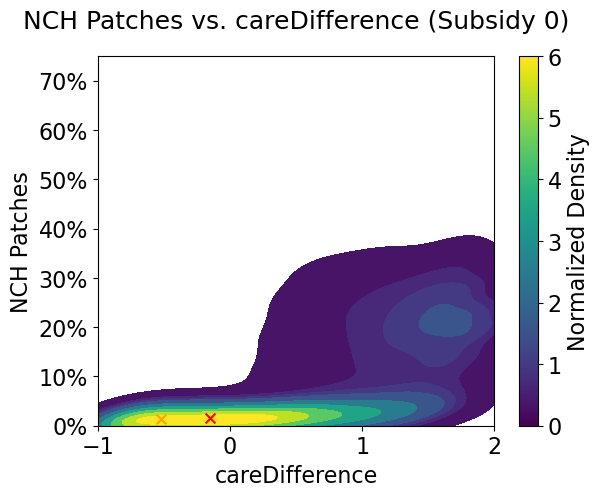

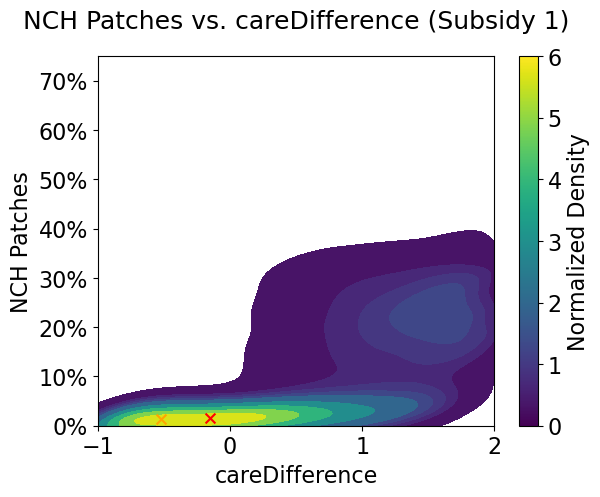

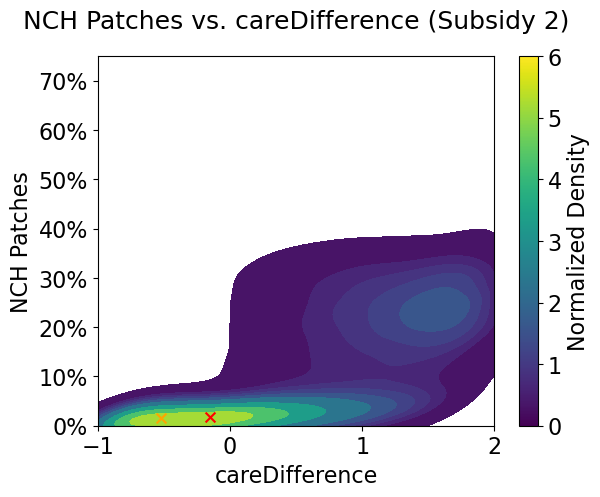

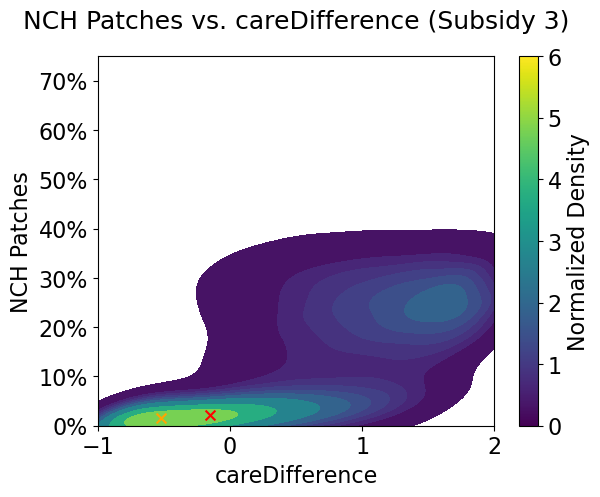

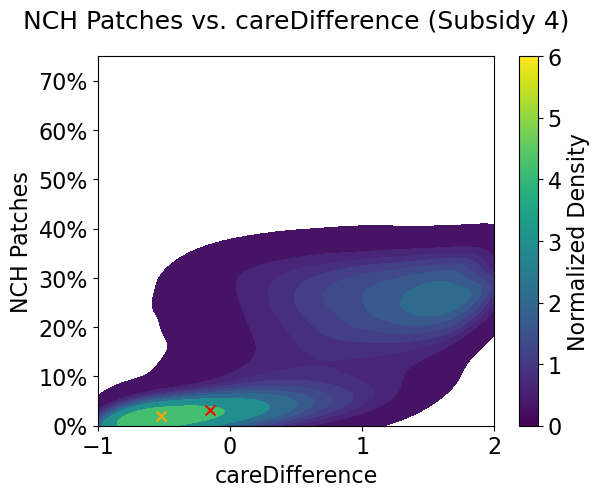

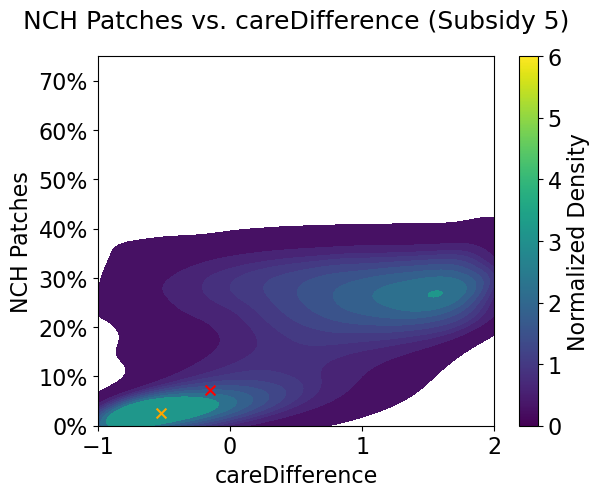

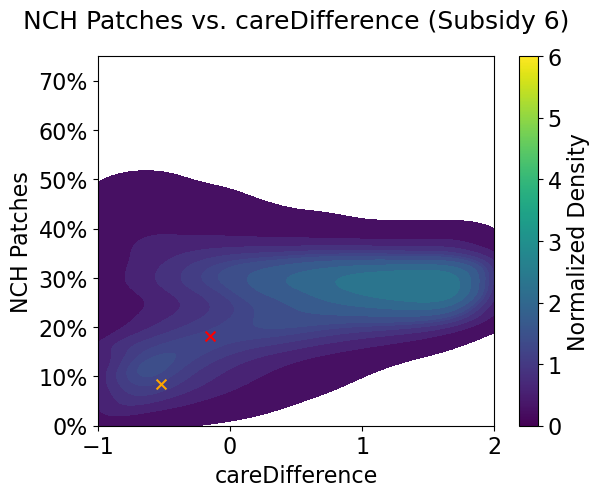

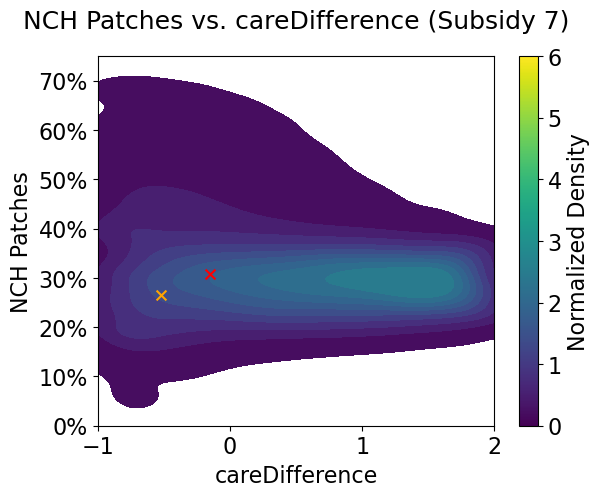

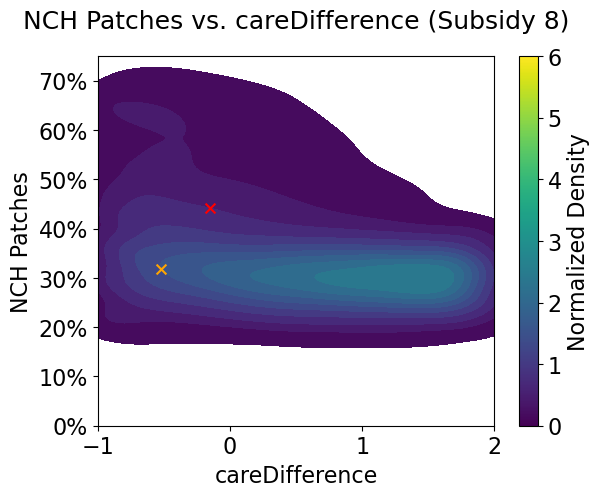

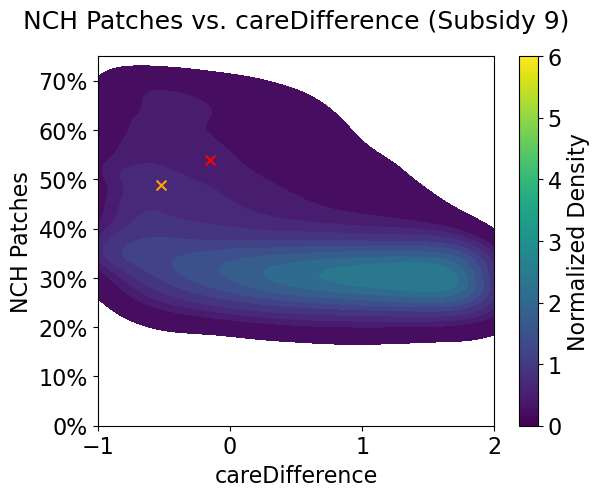

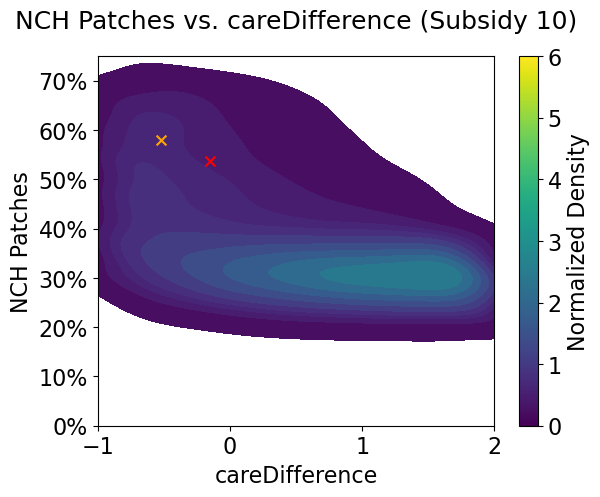

In [ ]:
# trying out careFarmMean + careLandscapeMean - carePatchMean

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# calibrated careFarmMean-carePatchMean
x_vietnam=-0.15
x_cambodia=-0.52

for subsidy in range(subsidy_max+1):
    fig, ax = plt.subplots()
    
    x = data[subsidy]['careFarmerMean'] + data[subsidy]['careOthersMean'] - data[subsidy]['carePatchMean']
    y = data[subsidy]['listNCHCells']
    
    kde_x = gaussian_kde(x)
    x_density = kde_x(x)

    weights = 1 / (x_density)
    kde=sns.kdeplot(x=x, y=y, weights=weights, fill=True, cmap='viridis', thresh=0.01, ax=ax,
                     cbar=False)

    norm = plt.Normalize(vmin=0, vmax=6)
    for collection in kde.collections:
        collection.set_norm(norm)

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])

    fig.colorbar(sm, ax=ax, label='Normalized Density')

    # Vietnam and Cambodia
    ax.scatter(x_vietnam, country_data['Vietnam'][subsidy], color='red', s=50, marker='x', label='Vietnam')
    ax.scatter(x_cambodia, country_data['Cambodia'][subsidy], color='orange', s=50, marker='x', label='Cambodia')

    plt.ylim(0, 0.75)
    plt.xlim(-1, 2)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage))

    plt.ylabel('NCH Patches')
    plt.xlabel("careDifference")
    plt.title('NCH Patches vs. careDifference (Subsidy '+str(subsidy)+')', fontsize = title_size, pad=padding_title_size)
    plt.show()

    fig.savefig(join(directory, 'Figures', 'careFarmMean + careLandscapeMean - carePatchMean', str(subsidy)+'_NCH.png'), dpi=600, bbox_inches='tight')

# summary figure of percent of income from NCH

In [3]:
# finding average values for Vietnam and Cambodia across farm size and heterogeneity experiments

df=pd.read_csv(join(directory, sensitivity_folder, 'farm_size_analysis.csv'))

subsidy_max=10

nch_data=dict()
production_data=dict()

country='Vietnam'
nch_data[country]=[[] for _ in range(subsidy_max+1)]
production_data[country]=[[] for _ in range(subsidy_max+1)]

ind=0
prev_ind=ind
while ind < len(df) and df['country'].iloc[ind+1]==country:
    ind+=1

full_list=df['listNCHCells'].tolist()[prev_ind:ind+1]
full_list_prod=df['listNetProduction'].tolist()[prev_ind:ind+1]
for i in range(len(full_list)):
    full_list[i]=full_list[i][1:-1].split(" ")
    full_list_prod[i]=full_list_prod[i][1:-1].split(" ")
    for j in range(len(full_list[i])):
        nch_data[country][j].append(float(full_list[i][j]))
        production_data[country][j].append(float(full_list_prod[i][j]))

country='Cambodia'
nch_data[country]=[[] for _ in range(subsidy_max+1)]
production_data[country]=[[] for _ in range(subsidy_max+1)]

ind=0
prev_ind=ind
while ind < len(df) and df['country'].iloc[ind+1]==country:
    ind+=1

full_list=df['listNCHCells'].tolist()[ind+1:]
full_list_prod=df['listNetProduction'].tolist()[ind+1:]
for i in range(len(full_list)):
    full_list[i]=full_list[i][1:-1].split(" ")
    full_list_prod[i]=full_list_prod[i][1:-1].split(" ")
    for j in range(len(full_list[i])):
        nch_data[country][j].append(float(full_list[i][j]))
        production_data[country][j].append(float(full_list_prod[i][j]))


# heterogeniety
df=pd.read_csv(join(directory, sensitivity_folder, 'heterogeneity_analysis.csv'))

country='Vietnam'

ind=0
prev_ind=ind
while ind < len(df) and df['country'].iloc[ind+1]==country:
    ind+=1

full_list=df['listNCHCells'].tolist()[prev_ind:ind+1]
full_list_prod=df['listNetProduction'].tolist()[prev_ind:ind+1]
for i in range(len(full_list)):
    full_list[i]=full_list[i][1:-1].split(" ")
    full_list_prod[i]=full_list_prod[i][1:-1].split(" ")
    for j in range(len(full_list[i])):
        nch_data[country][j].append(float(full_list[i][j]))
        production_data[country][j].append(float(full_list_prod[i][j]))


country='Cambodia'
full_list=df['listNCHCells'].tolist()[ind+1:]
full_list_prod=df['listNetProduction'].tolist()[ind+1:]
for i in range(len(full_list)):
    full_list[i]=full_list[i][1:-1].split(" ")
    full_list_prod[i]=full_list_prod[i][1:-1].split(" ")
    for j in range(len(full_list[i])):
        nch_data[country][j].append(float(full_list[i][j]))
        production_data[country][j].append(float(full_list_prod[i][j]))


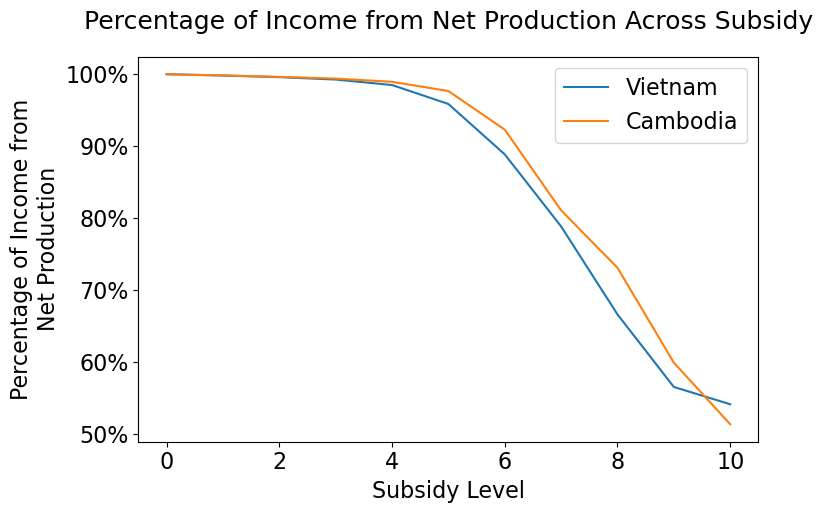

In [39]:
vals=dict()
# calculating values
for country in countries:
    vals[country]=[]
    for subsidy in range(11):
        nch_income=sum(nch_data[country][subsidy])*subsidy/len(nch_data[country][subsidy])
        production=sum(production_data[country][subsidy])/len(nch_data[country][subsidy])
        vals[country].append(production/(production+nch_income))

plt.figure(figsize=[8, 5])

plt.plot([subsidy for subsidy in range(11)], vals['Vietnam'], label='Vietnam')
plt.plot([subsidy for subsidy in range(11)], vals['Cambodia'], label='Cambodia')

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage))
plt.legend()

plt.ylabel('Percentage of Income from\nNet Production')
plt.xlabel("Subsidy Level")
plt.title('Percentage of Income from Net Production Across Subsidy', fontsize = title_size, pad=padding_title_size)

plt.savefig(join(directory, 'Figures', 'income_from_production.png'), dpi=600, bbox_inches='tight')
plt.show()

# same but with global sensitivity analysis

In [8]:
nch_data=dict()
production_data=dict()

vals=[[] for _ in range(subsidy_max+1)]

for i in range(len(sensitivity_csv)):
    curr_subsidy=sensitivity_csv['subsidy'][i]
    subsidy_income=sensitivity_csv['listNCHCells'][i]*curr_subsidy
    vals[curr_subsidy].append(sensitivity_csv['listNetProduction'][i]/(subsidy_income+sensitivity_csv['listNetProduction'][i]))
    
for subsidy in range(subsidy_max+1):
    vals[subsidy]=np.array(vals[subsidy])

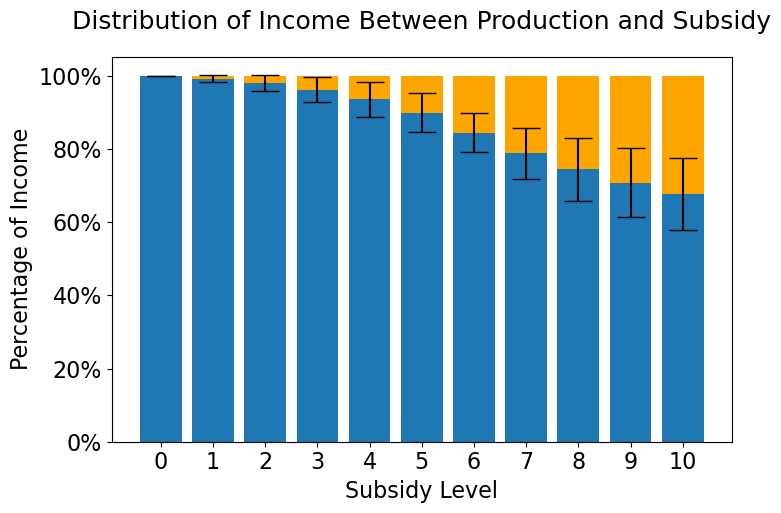

In [23]:

plt.figure(figsize=[8, 5])

x=[subsidy for subsidy in range(subsidy_max+1)]
y=np.array([_.mean() for _ in vals])

plt.bar(x, y, yerr=[_.std() for _ in vals], label='Production', capsize=10)
plt.bar(x, 1-y, bottom=y, label='Subsidy', color='Orange')
# plt.bar([subsidy for subsidy in range(subsidy_max+1)], [_.mean() for _ in vals])
# plt.errorbar([subsidy for subsidy in range(subsidy_max+1)], [_.mean() for _ in vals], yerr=[_.std() for _ in vals], capsize=10, fmt='o', color='black')

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage))

# plt.legend()
plt.xticks([subsidy for subsidy in range(subsidy_max+1)])
plt.ylabel('Percentage of Income')
plt.xlabel("Subsidy Level")
plt.title('Distribution of Income Between Production and Subsidy', fontsize = title_size, pad=padding_title_size)

plt.savefig(join(directory, 'Figures', 'income_from_production_global.png'), dpi=600, bbox_inches='tight')
plt.show()

# OLS regression on global sensitivity analysis

In [15]:
# standardizing all outcomes to max value 1

outcomes_df=sensitivity_csv.iloc[:, 11:].copy()
# only include model parameters
parameters_df=sensitivity_csv.iloc[:, 3:10].copy()
outcomes_df.columns=metrics_title

import statsmodels.api as sm
from itertools import combinations

for column in range(len(parameters_df.columns)):
    parameters_df.iloc[:,column]/=max(parameters_df.iloc[:,column])

for column in outcomes_df.columns:
    outcomes_df[column]=outcomes_df[column]/max(outcomes_df[column])

df = parameters_df.copy()
all_columns = df.columns.sort_values()
for i in range(2, 3):
    for combination in combinations(all_columns, i):
        if len(combination) > 1:
            col_name = '*'.join(combination)
            df[col_name] = parameters_df[list(combination)].prod(axis=1)

df = sm.add_constant(df)
coeff_dfs=[]

for column in outcomes_df.columns:
    y = outcomes_df[column].values
    model = sm.OLS(y, df).fit()

    print("\n", column)
    print(model.summary())

    coefficients = model.params
    sorted_coefs = coefficients.reindex(coefficients.abs().sort_values(ascending=False).index)
    p_values = model.pvalues.reindex(sorted_coefs.index)

    temp_df=pd.DataFrame({'Coefficient': sorted_coefs, 'P-value': p_values})
    
    # include only p-value<0.1
    coeff_dfs.append(temp_df[temp_df['P-value'] < 0.1])


 Income Per Patch
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     6049.
Date:                Sun, 06 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:16:49   Log-Likelihood:             4.3933e+05
No. Observations:              517000   AIC:                        -8.786e+05
Df Residuals:                  516971   BIC:                        -8.783e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [17]:
for i in range(len(coeff_dfs)):
    coeff_dfs[i].to_csv(os.path.join(directory, sensitivity_folder, sensitivity_results+'_parameters', metrics_title[i]+".csv"))

In [18]:
param_dict=dict()
for parameter in parameters_df.columns:
    param_dict[parameter]=pd.DataFrame(columns=['Coefficient', 'P-value'])
    for i in range(len(coeff_dfs)):
        for row in coeff_dfs[i].index:
            if parameter in row:
                temp=row+', '+metrics_title[i]
                param_dict[parameter].loc[temp]=coeff_dfs[i].loc[row]
    param_dict[parameter].sort_values(by='Coefficient', key=abs, inplace=True, ascending=False)


In [19]:
for col in param_dict.keys():
    param_dict[col].to_csv(os.path.join(directory, sensitivity_folder, sensitivity_results+"_parameters_metrics", col+".csv"))

# sorted table

In [50]:
# standardizing all outcomes to max value 1

outcomes_df=sensitivity_csv.iloc[:, 11:].copy()
# only include model parameters
parameters_df=sensitivity_csv.iloc[:, 3:10].copy()
outcomes_df.columns=metrics_title

import statsmodels.api as sm
from itertools import combinations

for column in range(len(parameters_df.columns)):
    parameters_df.iloc[:,column]/=max(parameters_df.iloc[:,column])

for column in outcomes_df.columns:
    outcomes_df[column]=outcomes_df[column]/max(outcomes_df[column])

df = parameters_df.reindex(sorted(parameters_df.columns), axis=1)
all_columns = df.columns
for i in range(2, 3):
    for combination in combinations(all_columns, i):
        if len(combination) > 1:
            col_name = '*'.join(combination)
            df[col_name] = parameters_df[list(combination)].prod(axis=1)

df = sm.add_constant(df)
coeff_dfs=[]

full_df=pd.DataFrame(columns=metrics_ordered)

for column in metrics_ordered:
    y = outcomes_df[column].values
    model = sm.OLS(y, df).fit()

    print("\n", column)
    print(model.summary())

    coefficients = model.params
    p_values=model.pvalues
    for i in range(len(p_values)):
        coeff="{:.3f}".format(round(coefficients[i], 3))
        p=round(p_values[i], 5)
        if p>=0.001:
            coeff+="ns"
        # if p<0.01:
        #     coeff+="***"
        # elif p<0.05:
        #     coeff+="**"
        # elif p<0.1:
        #     coeff+="*"
        coefficients[i]=coeff
    full_df[column]=coefficients
full_df=full_df.iloc[1:]


 Non-HS Strategy
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                 1.088e+04
Date:                Sun, 06 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:42:24   Log-Likelihood:                 44263.
No. Observations:              517000   AIC:                        -8.847e+04
Df Residuals:                  516971   BIC:                        -8.814e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [52]:
full_df.to_csv(os.path.join(directory, sensitivity_folder, 'full_sensitivity_table.csv'))